In [88]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shared_functions as sf

import math

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

### Load in data

In [3]:
# Basic EDA
original_data = pd.read_csv('train.csv')
data = original_data.copy()

In [5]:
# Plot Functions
SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

# Feature Selection 

## Class 3 Variables: 
### Drop variables with almost all missing values
Missing values look ok - some easy candidates to remove from our feature set. 

NaN     1369
Grvl      50
Pave      41
Name: Alley, dtype: int64
NaN    1453
Gd        3
Ex        2
Fa        2
Name: PoolQC, dtype: int64
NaN      1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64
NaN     1406
Shed      49
Gar2       2
Othr       2
TenC       1
Name: MiscFeature, dtype: int64


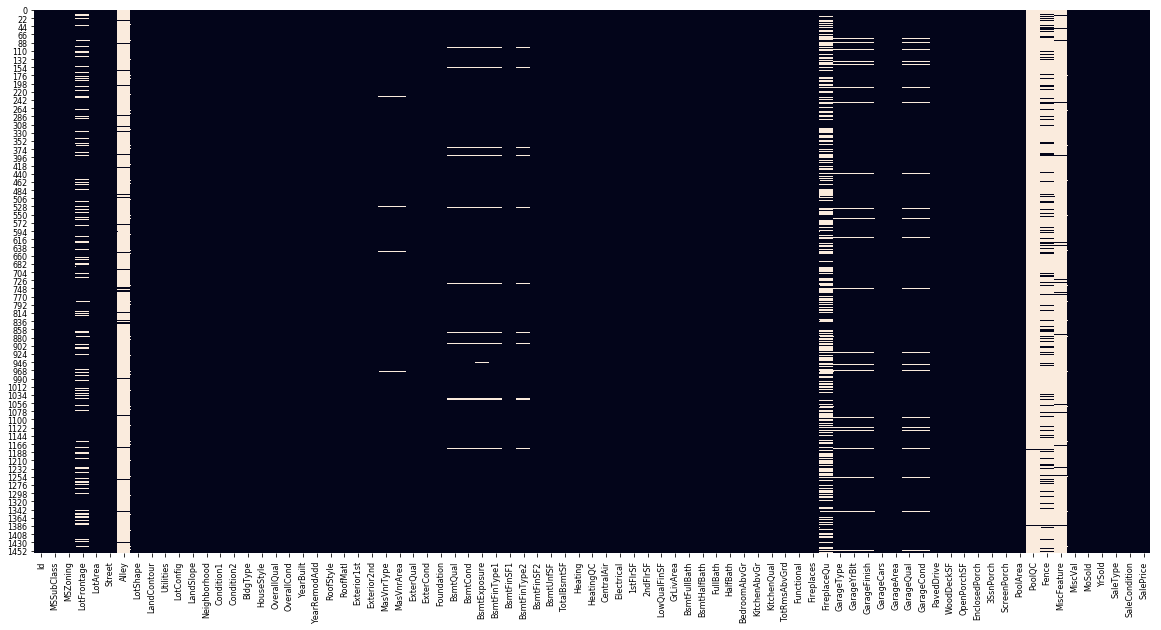

In [6]:
# Missing Values
plt.figure(figsize=(20,10))
sns.heatmap(original_data.isnull(), cbar=False)
plt.savefig('./missing_EDA.pdf')

# Drop these variables that have a lot missing
print(original_data['Alley'].value_counts(dropna = False))
print(original_data['PoolQC'].value_counts(dropna = False))
print(original_data['Fence'].value_counts(dropna = False))
print(original_data['MiscFeature'].value_counts(dropna = False))

# DROP the 4 variables
data = data.drop(columns=['Alley', 'PoolQC', 'Fence', 'MiscFeature'])

In [7]:
print(original_data['Street'].value_counts())
print(original_data['Utilities'].value_counts())

# Drop the 2 variables 
data = data.drop(columns = ['Street', 'Utilities'])

Pave    1454
Grvl       6
Name: Street, dtype: int64
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


# Class 1 variables

In [8]:
# MS-ZONING
original_data['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

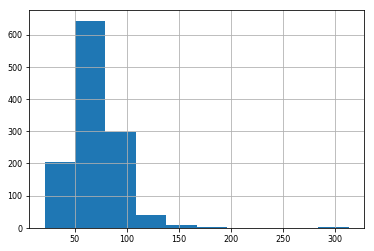

In [9]:
# LOTFRONTAGE
# Outlier here may have high influence on the model
original_data['LotFrontage'].hist()

In [10]:
# Neighborhood
original_data['Neighborhood'].value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [11]:
# Building Type
original_data['BldgType'].value_counts()

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

In [12]:
# Building Type
# Consider bucketing some categories later
original_data['HouseStyle'].value_counts()

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

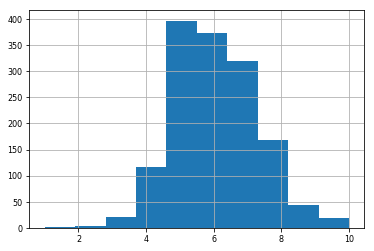

In [13]:
# Overall Quality
original_data['OverallQual'].value_counts()

# Change to categorical
data['OverallQual'] = original_data['OverallQual'].astype('category')
data['OverallQual'].cat.reorder_categories([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ordered=True)
data['OverallQual'].hist()

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """


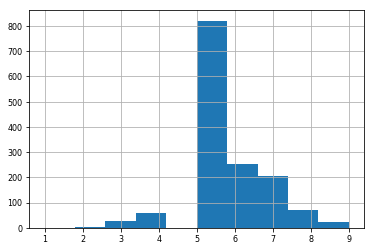

In [14]:
# Overall Condition
original_data['OverallCond']

# Change to categorical 
data['OverallCond'] = original_data['OverallCond'].astype('category', ordered=True)
data['OverallCond'].hist()

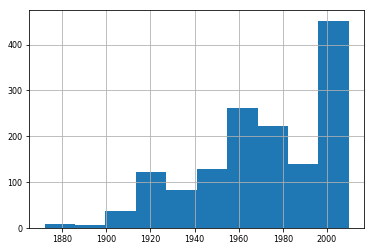

In [15]:
original_data['YearBuilt'].hist()

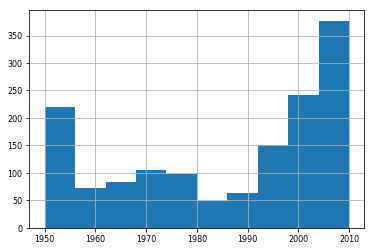

In [16]:
original_data['YearRemodAdd'].hist()

In [17]:
original_data['Exterior1st'].value_counts() #!!!
original_data['Exterior2nd'].value_counts()

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

In [18]:
original_data['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

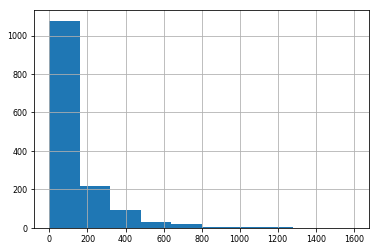

In [19]:
original_data['MasVnrArea'].hist()

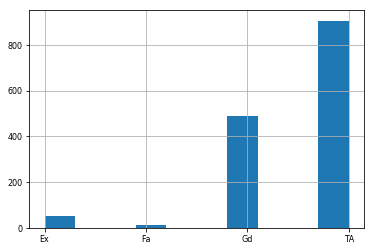

In [20]:
original_data['ExterQual'].hist()

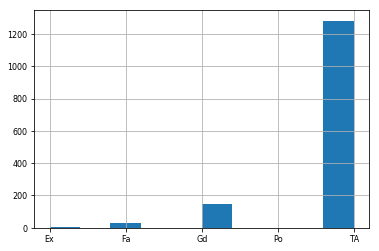

In [21]:
original_data["ExterCond"].hist()

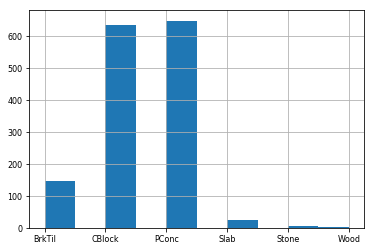

In [22]:
original_data["Foundation"].hist()

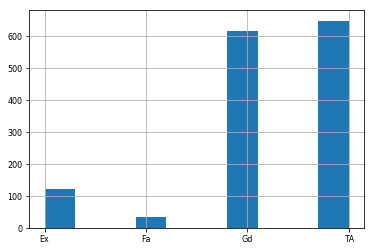

In [23]:
original_data["BsmtQual"].hist()

In [24]:
original_data["BsmtCond"].value_counts(dropna = False)

TA     1311
Gd       65
Fa       45
NaN      37
Po        2
Name: BsmtCond, dtype: int64

In [25]:
original_data["BsmtExposure"].value_counts(dropna = False)

No     953
Av     221
Gd     134
Mn     114
NaN     38
Name: BsmtExposure, dtype: int64

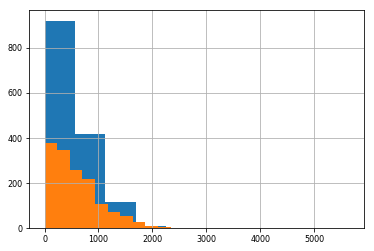

In [26]:
original_data["BsmtFinSF1"].hist()
original_data["BsmtUnfSF"].hist()

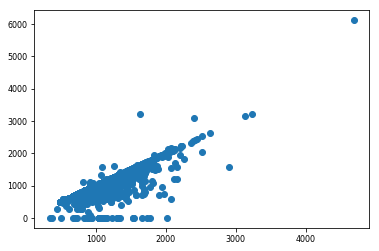

In [27]:
# Drop the aggregate BsmtSF variable
test = pd.DataFrame()
test['DiffBsmtSF'] = original_data["TotalBsmtSF"] - original_data['BsmtFinSF1'] - original_data['BsmtUnfSF'] - original_data['BsmtFinSF2']
test['DiffBsmtSF'].value_counts()

# Remove variable
data = data.drop(columns=['TotalBsmtSF'])

# Correlation with 1stFlrSF - very highly correlated, which makes sense. 
plt.scatter(original_data['1stFlrSF'], original_data['TotalBsmtSF'])

In [28]:
original_data["Heating"].value_counts(dropna = True)

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

In [29]:
original_data["HeatingQC"].value_counts(dropna = True)

Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

In [30]:
original_data["CentralAir"].value_counts(dropna = True)

Y    1365
N      95
Name: CentralAir, dtype: int64

In [31]:
original_data["Electrical"].value_counts(dropna = True)

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

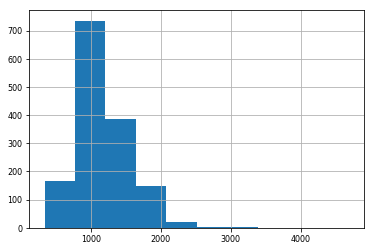

In [32]:
original_data["1stFlrSF"].hist()

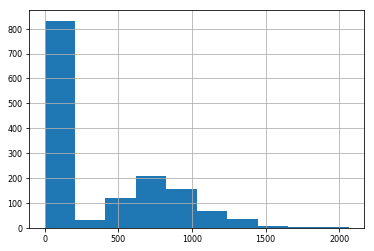

In [33]:
original_data["2ndFlrSF"].hist()
# should change to NaN if no 2nd floor?

In [34]:
# Is GrLivArea simply the sum of 1st and 2nd?
# Most of hte time it is - there are 5 observations that are not, but doesn't seem like a goood reason to keep
test = pd.DataFrame()
test['GrLivArea'] = original_data["GrLivArea"]
test['1stAnd2nd'] = original_data["1stFlrSF"] + original_data["2ndFlrSF"]
test['Diff'] = test['GrLivArea'] - test['1stAnd2nd']
test['Diff'].value_counts()

data['GrLivArea']

0       1710
1       1262
2       1786
3       1717
4       2198
5       1362
6       1694
7       2090
8       1774
9       1077
10      1040
11      2324
12       912
13      1494
14      1253
15       854
16      1004
17      1296
18      1114
19      1339
20      2376
21      1108
22      1795
23      1060
24      1060
25      1600
26       900
27      1704
28      1600
29       520
30      1317
31      1228
32      1234
33      1700
34      1561
35      2452
36      1097
37      1297
38      1057
39      1152
40      1324
41      1328
42       884
43       938
44      1150
45      1752
46      2149
47      1656
48      1452
49       955
50      1470
51      1176
52       816
53      1842
54      1360
55      1425
56      1739
57      1720
58      2945
59       780
60      1158
61      1111
62      1370
63      1710
64      2034
65      2473
66      2207
67      1479
68       747
69      2287
70      2223
71       845
72      1718
73      1086
74      1605
75       988
76       952

In [35]:
original_data['FullBath'].value_counts()

2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64

In [36]:
original_data['KitchenQual'].value_counts()

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

In [37]:
original_data['TotRmsAbvGrd'].value_counts()

6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
14      1
2       1
Name: TotRmsAbvGrd, dtype: int64

In [38]:
original_data['Fireplaces'].value_counts()

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

In [39]:
original_data['FireplaceQu'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [40]:
original_data['GarageType'].value_counts()

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

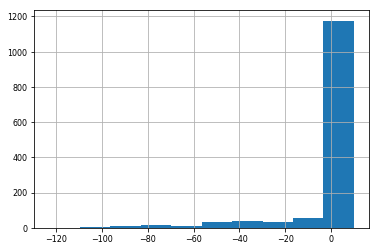

In [41]:
test['diffYrbuilt']=original_data['YearBuilt']-original_data['GarageYrBlt']
test['diffYrbuilt'].hist()

In [42]:
original_data['GarageFinish'].value_counts()

Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

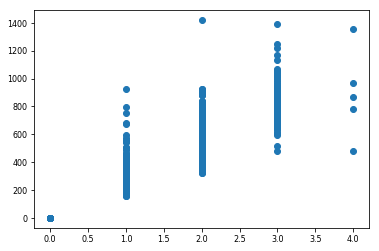

In [43]:
# Remove garage cars - more coarse and subjective measure of garage area
original_data['GarageCars'].value_counts()
plt.scatter(original_data['GarageCars'],original_data['GarageArea'])
data = data.drop(columns=['GarageCars'])

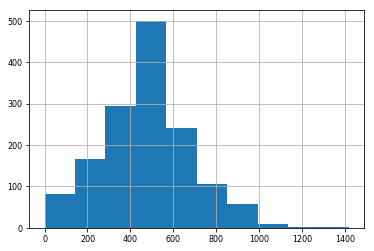

In [44]:
original_data['GarageArea'].hist()

In [45]:
original_data['GarageQual'].value_counts()

TA    1311
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64

In [46]:
original_data['GarageCond'].value_counts()

TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

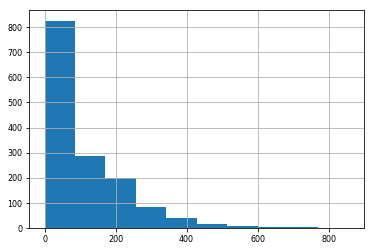

In [47]:
original_data['WoodDeckSF'].hist()

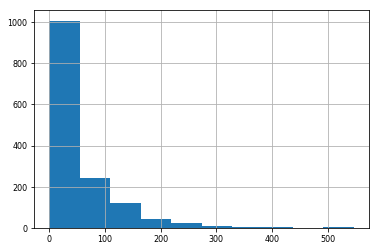

In [48]:
original_data['OpenPorchSF'].hist()

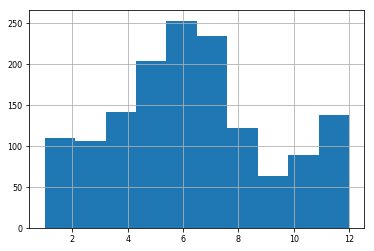

In [49]:
original_data['MoSold'].hist()

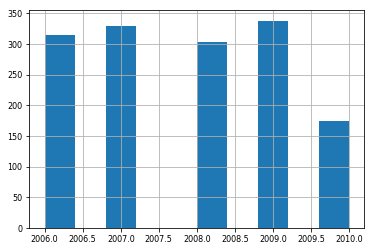

In [50]:
original_data['YrSold'].hist()

In [51]:
# Create date variable
data['YrMoSold'] = pd.to_datetime(data['YrSold'].astype(str) + data['MoSold'].astype(str), format='%Y%m')

In [52]:
data['SaleType'].value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

In [53]:
original_data['SaleCondition'].value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

## Class 2 Variables

In [54]:
# Changed to categorical
data['MSSubClass'] = original_data['MSSubClass'].astype('category')


In [55]:
# May want to bin later - some large outliers
original_data['LotArea'].value_counts()

7200      25
9600      24
6000      17
10800     14
9000      14
8400      14
1680      10
7500       9
8125       8
9100       8
6120       8
6240       8
3182       7
7800       6
8450       6
10000      5
4500       5
4435       5
5000       5
10140      5
9750       5
10400      5
5400       5
7018       4
11700      4
9375       4
8800       4
9900       4
8750       4
6600       4
7000       4
8640       4
10625      4
13125      4
11250      4
8544       4
8520       4
8500       4
6762       3
10500      3
2117       3
12090      3
11600      3
10440      3
8712       3
11500      3
10200      3
7750       3
14115      3
9200       3
2280       3
9084       3
4426       3
13891      3
9120       3
8000       3
8777       3
3675       3
7875       3
9920       3
8012       3
2522       3
11645      2
7420       2
15611      2
5500       2
9591       2
6292       2
9571       2
8172       2
10382      2
9500       2
11616      2
13600      2
9525       2
9790       2
7917       2

In [56]:
original_data['LotShape'].value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

In [57]:
original_data['LandContour'].value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

In [58]:
original_data['LotConfig'].value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

In [59]:
original_data['LandSlope'].value_counts()

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

In [60]:
original_data['Condition1'].value_counts()
original_data['Condition2'].value_counts()

Norm      1445
Feedr        6
PosN         2
RRNn         2
Artery       2
PosA         1
RRAe         1
RRAn         1
Name: Condition2, dtype: int64

In [61]:
original_data['RoofStyle'].value_counts()

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

In [62]:
original_data['RoofMatl'].value_counts()

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Membran       1
ClyTile       1
Metal         1
Roll          1
Name: RoofMatl, dtype: int64

In [63]:
original_data['BsmtFinType1'].value_counts()

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

In [64]:
original_data['BsmtFinType2'].value_counts()

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [65]:
# Drop - mostly 0 and very low variation
original_data['LowQualFinSF'].value_counts()
data = data.drop(columns=['LowQualFinSF'])

In [66]:
original_data['BsmtFullBath'].value_counts()

0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

In [67]:
original_data['BsmtHalfBath'].value_counts()

0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64

In [68]:
original_data['HalfBath'].value_counts()

0    913
1    535
2     12
Name: HalfBath, dtype: int64

In [69]:
original_data['BedroomAbvGr'].value_counts()

3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

In [70]:
original_data['KitchenAbvGr'].value_counts()

1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

In [71]:
original_data['BedroomAbvGr'].value_counts()

3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

In [72]:
original_data['Functional'].value_counts()

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [73]:
original_data['PavedDrive'].value_counts()

Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

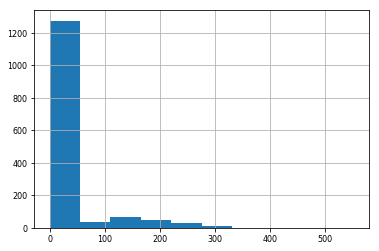

In [74]:
original_data['EnclosedPorch'].hist()

In [75]:
original_data['ScreenPorch'].value_counts()

0      1344
192       6
224       5
120       5
189       4
180       4
160       3
168       3
144       3
126       3
147       3
90        3
200       2
198       2
216       2
184       2
259       2
100       2
176       2
170       2
288       2
142       2
153       1
154       1
152       1
155       1
145       1
156       1
143       1
322       1
140       1
161       1
128       1
122       1
410       1
119       1
116       1
99        1
95        1
80        1
63        1
60        1
53        1
40        1
130       1
175       1
163       1
165       1
291       1
287       1
276       1
273       1
271       1
266       1
265       1
263       1
260       1
252       1
234       1
233       1
225       1
374       1
222       1
220       1
210       1
204       1
197       1
385       1
190       1
396       1
185       1
182       1
440       1
178       1
312       1
480       1
Name: ScreenPorch, dtype: int64

In [76]:
original_data['PoolArea'].value_counts()

0      1453
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64

In [77]:
# Drop - most of it is 0 and is an uninterpretable feature 
original_data['MiscVal'].value_counts()
data = data.drop(columns=['MiscVal'])

### Dummification of Categorical Variables

In [78]:
# Binarize all categorical
data = pd.get_dummies(data)
data.describe()

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold,SalePrice,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_1,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functiona

### Imputation of Numeric Variables 

In [94]:
# Impute all numeric missings (all dummy missings are coded 0)
imp = SimpleImputer(missing_values = np.nan, strategy = 'median')
data_ex_yrmonsold = data.drop(columns=['YrMoSold'])
data_temp = imp.fit_transform(data_ex_yrmonsold)
data_temp = pd.DataFrame(data_temp, columns = data_ex_yrmonsold.columns)
                              
# Do 
data = pd.concat([data_temp, pd.DataFrame(data['YrMoSold'])], axis = 1)

# Algorithmic Variable Selection

Lots of continuous variables and categorical ones - and not a lot of data (1460). Will probably not be a linear combination of features - probably some kind of tree-based model?

In [80]:
# Categorical
original_data.select_dtypes(include='object').apply(lambda x: x.value_counts()).T.stack()


MSZoning       C (all)      10.0
               FV           65.0
               RH           16.0
               RL         1151.0
               RM          218.0
Street         Grvl          6.0
               Pave       1454.0
Alley          Grvl         50.0
               Pave         41.0
LotShape       IR1         484.0
               IR2          41.0
               IR3          10.0
               Reg         925.0
LandContour    Bnk          63.0
               HLS          50.0
               Low          36.0
               Lvl        1311.0
Utilities      AllPub     1459.0
               NoSeWa        1.0
LotConfig      Corner      263.0
               CulDSac      94.0
               FR2          47.0
               FR3           4.0
               Inside     1052.0
LandSlope      Gtl        1382.0
               Mod          65.0
               Sev          13.0
Neighborhood   Blmngtn      17.0
               Blueste       2.0
               BrDale       16.0
          

Generally most of the value appear to be OK - not many missing values, but the categories can be fairly unbalanced in some cases (e.g. most "Sale Condition" is normal). 

### Examine Features that are highly correlated

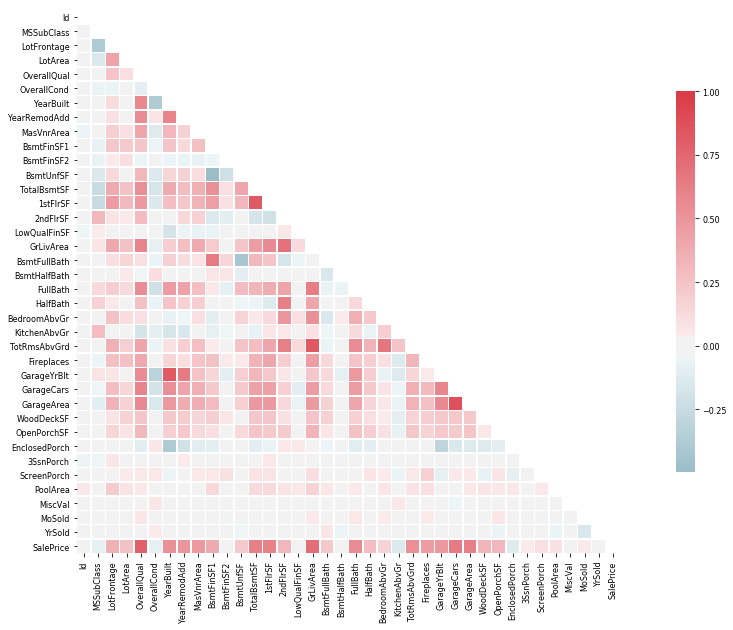

In [81]:
# Correlation matrix
plt.figure(figsize=(20,10))
corr = original_data.select_dtypes(exclude='object').corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

### Use an algorithmic Feature Selection method

In [82]:
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.impute import SimpleImputer

# Set initial variables to remove in a backward selection process until top variable is less than 0.1 impt
# top_variables = ['SalePrice', 'OverallQual', 'GarageCars', 'GrLivArea', 'ExterQual', 'GarageArea', 'YearBuilt', 'TotalBsmtSF', 'BsmtQual', '1stFlrSF', 'GarageYrBlt']
top_variables = ['SalePrice']
# Binarize all categorical
original_data_dummy = pd.get_dummies(original_data.drop(top_variables, axis = 1))

# Impute all numeric
imp = SimpleImputer(missing_values = np.nan, strategy = 'median')
original_data_dummy_array = imp.fit_transform(original_data_dummy)

rf = RandomForestRegressor()
rf.fit(original_data_dummy_array, original_data['SalePrice'])
rf.feature_importances_

feature_importances = pd.DataFrame(rf.feature_importances_.round(4),
                                   index = original_data_dummy.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

feature_importances
# Plot
#feature_importances.nlargest(30,'importance').plot(kind='barh')

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,importance
OverallQual,0.5777
GrLivArea,0.1039
2ndFlrSF,0.0496
TotalBsmtSF,0.0374
1stFlrSF,0.0312
BsmtFinSF1,0.0217
GarageArea,0.0193
GarageCars,0.0164
LotArea,0.0139
YearBuilt,0.0125


### Keep variables that are highly correlated with the predictor (continuous)

In [83]:
corr_with_salep = original_data.select_dtypes(exclude='object').drop("SalePrice", axis=1).apply(lambda x: x.corr(original_data.SalePrice))
np.abs(corr_with_salep).sort_values(ascending=False)

# For now I just keep variables that have 0.3 and above correlation

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
Id               0.021917
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
dtype: float64

# Run Models

In [89]:
# Labels
train_labels = data['SalePrice']

# Data
split = 200
train_data = data.drop(columns=['SalePrice','YrMoSold'], axis = 1)

# Split train data and dev Data
dev_data = train_data[:split]
train_data = train_data[split:]
dev_labels = train_labels[:split]
train_labels = train_labels[split:]

train_data.describe()

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_1,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Func

In [91]:
linearmodel = LinearRegression()
linearmodel.fit(train_data, train_labels)
dev_pred = linearmodel.predict(dev_data)

# Mean Abs % Error
print(np.mean(np.abs(dev_pred-dev_labels)/dev_labels))

# RMSLE
sf.rmsle(dev_labels, dev_pred)

0.10778294874692466


0.2201694489050211

### Run a Random Forest 

In [92]:
# Run RF
rf = RandomForestRegressor()
rf.fit(train_data, train_labels)
dev_pred = rf.predict(dev_data)

# Mean Abs % Error
print(np.mean(np.abs(dev_pred-dev_labels)/dev_labels))

# RMSLE
sf.rmsle(dev_labels, dev_pred)

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.11255823560267832


0.15409080178369125

## Output file


In [93]:
data.to_csv('clean_data.csv')